In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Test download
test_data = yf.download('AAPL', start='2023-01-01', end='2024-01-01')
print(f"Setup successful! Downloaded {len(test_data)} days of data")
test_data.head()

Matplotlib is building the font cache; this may take a moment.
/var/folders/0r/wj69vt3538bf33wvm2rmpc980000gn/T/ipykernel_11369/2830256941.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  test_data = yf.download('AAPL', start='2023-01-01', end='2024-01-01')
[*********************100%***********************]  1 of 1 completed

Setup successful! Downloaded 250 days of data


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2023-01-03,123.470612,129.226052,122.582119,128.613985,112117500
2023-01-04,124.744125,127.014716,123.480495,125.267347,89113600
2023-01-05,123.421257,126.136090,123.164587,125.504275,80962700
2023-01-06,127.962425,128.623856,123.292916,124.398597,87754700
2023-01-09,128.485641,131.703962,128.228972,128.801557,70790800


In [2]:
# Download data for multiple stocks
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'JPM', 'JNJ', 'PG', 'KO', 'DIS']
print(f"Downloading data for: {tickers}")

# Download 2 years of data
data = yf.download(tickers, start='2022-01-01', end='2024-01-01')
print(f"Data shape: {data.shape}")

# Look at the structure
print("\nData columns:")
print(data.columns.levels)

/var/folders/0r/wj69vt3538bf33wvm2rmpc980000gn/T/ipykernel_11369/3959214454.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start='2022-01-01', end='2024-01-01')
[*********************100%***********************]  10 of 10 completed

Data shape: (501, 50)

Data columns:
[['Close', 'High', 'Low', 'Open', 'Volume'], ['AAPL', 'AMZN', 'DIS', 'GOOGL', 'JNJ', 'JPM', 'KO', 'MSFT', 'PG', 'TSLA']]


In [3]:
# Get just the closing prices
close_prices = data['Close']
print("Close prices shape:", close_prices.shape)
close_prices.head()

Close prices shape: (501, 10)


Ticker,AAPL,AMZN,DIS,GOOGL,JNJ,JPM,KO,MSFT,PG,TSLA
Date,,,,,,,,,,
2022-01-03,178.645645,170.404495,154.189545,144.127121,154.672607,146.995773,53.403141,325.038025,149.405045,399.926666
2022-01-04,176.378342,167.522003,153.176422,143.538666,154.257858,152.568390,54.294693,319.464600,149.927841,383.196655
2022-01-05,171.686707,164.356995,152.645309,136.953644,155.285782,149.779129,54.744972,307.201050,150.606537,362.706665
2022-01-06,168.820694,163.253998,154.327240,136.926315,154.753815,151.370377,54.456799,304.773560,149.340836,354.899994
2022-01-07,168.987564,162.554001,155.242004,136.200150,156.845688,152.870178,54.330711,304.928925,149.258316,342.320007


In [4]:
# Calculate 20-day momentum (20-day return)
momentum_period = 20
returns_20d = close_prices.pct_change(momentum_period)

print("20-day returns calculated!")
print(f"Data from {returns_20d.index[0]} to {returns_20d.index[-1]}")
returns_20d.tail()

20-day returns calculated!
Data from 2022-01-03 00:00:00 to 2023-12-29 00:00:00


Ticker,AAPL,AMZN,DIS,GOOGL,JNJ,JPM,KO,MSFT,PG,TSLA
Date,,,,,,,,,,
2023-12-22,0.019108,0.045523,-0.049379,0.035116,0.019410,0.090270,0.003660,-0.007551,-0.040296,0.072584
2023-12-26,0.017177,0.038449,-0.041227,0.037461,0.032126,0.099223,0.009687,-0.010433,-0.035044,0.086962
2023-12-27,0.014443,0.042916,-0.019735,0.023105,0.031128,0.103296,0.010199,-0.022550,-0.040909,0.059663
2023-12-28,0.022232,0.048250,-0.019518,0.038818,0.029387,0.103551,0.016964,-0.009423,-0.035731,0.037028
2023-12-29,0.013582,0.040044,-0.022718,0.054026,0.013449,0.089826,0.008385,-0.007574,-0.045466,0.034988


In [5]:
# Create trading signals based on momentum
def create_signals(returns_20d):
    # For each date, rank stocks by their 20-day momentum
    signals = pd.DataFrame(index=returns_20d.index, columns=returns_20d.columns)
    
    for date in returns_20d.index:
        day_returns = returns_20d.loc[date]
        
        # Remove any NaN values
        day_returns = day_returns.dropna()
        
        if len(day_returns) > 0:
            # Rank stocks: 1 = highest momentum, n = lowest momentum
            ranks = day_returns.rank(ascending=False)
            
            # Buy top 40% (momentum), sell bottom 40% (mean reversion)
            n_stocks = len(day_returns)
            top_threshold = n_stocks * 0.4
            bottom_threshold = n_stocks * 0.6
            
            # Create signals: 1 = buy, -1 = sell, 0 = hold
            for stock in ranks.index:
                if ranks[stock] <= top_threshold:
                    signals.loc[date, stock] = 1  # Buy signal
                elif ranks[stock] >= bottom_threshold:
                    signals.loc[date, stock] = -1  # Sell signal
                else:
                    signals.loc[date, stock] = 0  # Hold
    
    return signals

# Generate signals
signals = create_signals(returns_20d)
print("Trading signals created!")
print(f"Signals shape: {signals.shape}")

# Look at a sample of signals
print("\nSample signals (1=buy, -1=sell, 0=hold):")
signals.tail()

Trading signals created!
Signals shape: (501, 10)

Sample signals (1=buy, -1=sell, 0=hold):


Ticker,AAPL,AMZN,DIS,GOOGL,JNJ,JPM,KO,MSFT,PG,TSLA
Date,,,,,,,,,,
2023-12-22,-1,1,-1,1,0,1,-1,-1,-1,1
2023-12-26,-1,1,-1,1,0,1,-1,-1,-1,1
2023-12-27,-1,1,-1,0,1,1,-1,-1,-1,1
2023-12-28,-1,1,-1,1,0,1,-1,-1,-1,1
2023-12-29,0,1,-1,1,-1,1,-1,-1,-1,1


In [6]:
# Simulate trading the strategy
def backtest_strategy(close_prices, signals, initial_capital=10000):
    # Calculate daily returns for each stock
    daily_returns = close_prices.pct_change()
    
    # Initialize portfolio
    portfolio_value = [initial_capital]
    dates = []
    
    # Rebalance monthly (every 21 trading days)
    rebalance_freq = 21
    
    for i in range(len(signals)):
        current_date = signals.index[i]
        
        # Skip if we don't have enough data yet
        if i < momentum_period:
            continue
            
        # Rebalance portfolio every 21 days
        if i % rebalance_freq == 0:
            current_signals = signals.iloc[i]
            current_signals = current_signals.dropna()
            
            # Count buy and sell signals
            buy_signals = (current_signals == 1).sum()
            sell_signals = (current_signals == -1).sum()
            
            print(f"Date {current_date.date()}: {buy_signals} buys, {sell_signals} sells")
        
        # Calculate portfolio return for this day
        if i > momentum_period:
            day_returns = daily_returns.iloc[i]
            prev_signals = signals.iloc[i-1].dropna()
            
            # Portfolio return = average return of positions
            if len(prev_signals) > 0:
                portfolio_return = (day_returns * prev_signals).mean()
                if not pd.isna(portfolio_return):
                    new_value = portfolio_value[-1] * (1 + portfolio_return)
                    portfolio_value.append(new_value)
                    dates.append(current_date)
    
    return pd.Series(portfolio_value[1:], index=dates)

# Run backtest
portfolio_performance = backtest_strategy(close_prices, signals)
print(f"\nBacktest complete!")
print(f"Portfolio grew from $10,000 to ${portfolio_performance.iloc[-1]:,.2f}")
print(f"Total return: {(portfolio_performance.iloc[-1]/10000 - 1)*100:.2f}%")

Date 2022-02-02: 4 buys, 5 sells
Date 2022-03-04: 4 buys, 5 sells
Date 2022-04-04: 4 buys, 5 sells
Date 2022-05-04: 4 buys, 5 sells
Date 2022-06-03: 4 buys, 5 sells
Date 2022-07-06: 4 buys, 5 sells
Date 2022-08-04: 4 buys, 5 sells
Date 2022-09-02: 4 buys, 5 sells
Date 2022-10-04: 4 buys, 5 sells
Date 2022-11-02: 4 buys, 5 sells
Date 2022-12-02: 4 buys, 5 sells
Date 2023-01-04: 4 buys, 5 sells
Date 2023-02-03: 4 buys, 5 sells
Date 2023-03-07: 4 buys, 5 sells
Date 2023-04-05: 4 buys, 5 sells
Date 2023-05-05: 4 buys, 5 sells
Date 2023-06-06: 4 buys, 5 sells
Date 2023-07-07: 4 buys, 5 sells
Date 2023-08-07: 4 buys, 5 sells
Date 2023-09-06: 4 buys, 5 sells
Date 2023-10-05: 4 buys, 5 sells
Date 2023-11-03: 4 buys, 5 sells
Date 2023-12-05: 4 buys, 5 sells

Backtest complete!
Portfolio grew from $10,000 to $10,251.05
Total return: 2.51%


In [9]:
# Calculate key performance metrics
def calculate_metrics(portfolio_performance, benchmark_symbol='SPY'):
    # Download benchmark (S&P 500)
    benchmark = yf.download(benchmark_symbol, start='2022-01-01', end='2024-01-01')['Close']
    
    # Align dates
    common_dates = portfolio_performance.index.intersection(benchmark.index)
    portfolio_aligned = portfolio_performance.loc[common_dates]
    benchmark_aligned = benchmark.loc[common_dates]
    
    # Calculate returns
    portfolio_returns = portfolio_aligned.pct_change().dropna()
    benchmark_returns = benchmark_aligned.pct_change().dropna()
    
    # Performance metrics
    total_return_strategy = (portfolio_aligned.iloc[-1] / portfolio_aligned.iloc[0] - 1) * 100
    total_return_benchmark = (benchmark_aligned.iloc[-1] / benchmark_aligned.iloc[0] - 1) * 100
    
    # Sharpe ratio (assuming 2% risk-free rate)

In [10]:
# Let's debug step by step
print("Checking portfolio performance...")
print(f"Portfolio performance shape: {portfolio_performance.shape}")
print(f"Portfolio start date: {portfolio_performance.index[0]}")
print(f"Portfolio end date: {portfolio_performance.index[-1]}")
print(f"Portfolio start value: ${portfolio_performance.iloc[0]:,.2f}")
print(f"Portfolio end value: ${portfolio_performance.iloc[-1]:,.2f}")

# Simple calculation
simple_return = (portfolio_performance.iloc[-1] / portfolio_performance.iloc[0] - 1) * 100
print(f"Simple total return: {simple_return:.2f}%")

Checking portfolio performance...
Portfolio performance shape: (480,)
Portfolio start date: 2022-02-02 00:00:00
Portfolio end date: 2023-12-29 00:00:00
Portfolio start value: $10,083.29
Portfolio end value: $10,251.05
Simple total return: 1.66%


In [13]:
# Simplified metrics calculation
print("\nSIMPLIFIED PERFORMANCE SUMMARY")
print("=" * 40)

# Download SPY for comparison
spy = yf.download('SPY', start='2022-01-01', end='2024-01-01')['Close']

# Strategy performance - convert to float to avoid formatting issues
strategy_return = float((portfolio_performance.iloc[-1] / portfolio_performance.iloc[0] - 1) * 100)
spy_return = float((spy.iloc[-1] / spy.iloc[0] - 1) * 100)

print(f"Strategy Total Return: {strategy_return:.2f}%")
print(f"SPY Total Return: {spy_return:.2f}%")
print(f"Outperformance: {strategy_return - spy_return:.2f}%")

# Portfolio daily returns for Sharpe ratio
portfolio_daily_returns = portfolio_performance.pct_change().dropna()
strategy_sharpe = float((portfolio_daily_returns.mean() * 252) / (portfolio_daily_returns.std() * np.sqrt(252)))
print(f"Strategy Sharpe Ratio: {strategy_sharpe:.2f}")

print("\nKey Insights:")
print(f"- Your momentum strategy returned {strategy_return:.2f}% over 2 years")
print(f"- The S&P 500 (SPY) returned {spy_return:.2f}% over the same period")
if strategy_return > spy_return:
    print(f"- Your strategy OUTPERFORMED the market by {strategy_return - spy_return:.2f}%! 🎉")
else:
    print(f"- Your strategy underperformed the market by {spy_return - strategy_return:.2f}%")

/var/folders/0r/wj69vt3538bf33wvm2rmpc980000gn/T/ipykernel_11369/2195716798.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy = yf.download('SPY', start='2022-01-01', end='2024-01-01')['Close']
[*********************100%***********************]  1 of 1 completed


SIMPLIFIED PERFORMANCE SUMMARY
Strategy Total Return: 1.66%
SPY Total Return: 2.65%
Outperformance: -0.98%
Strategy Sharpe Ratio: 0.13

Key Insights:
- Your momentum strategy returned 1.66% over 2 years
- The S&P 500 (SPY) returned 2.65% over the same period
- Your strategy underperformed the market by 0.98%



/var/folders/0r/wj69vt3538bf33wvm2rmpc980000gn/T/ipykernel_11369/2195716798.py:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spy_return = float((spy.iloc[-1] / spy.iloc[0] - 1) * 100)


/var/folders/0r/wj69vt3538bf33wvm2rmpc980000gn/T/ipykernel_11369/108393139.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_aligned = yf.download('SPY', start=portfolio_performance.index[0], end=portfolio_performance.index[-1])['Close']
[*********************100%***********************]  1 of 1 completed


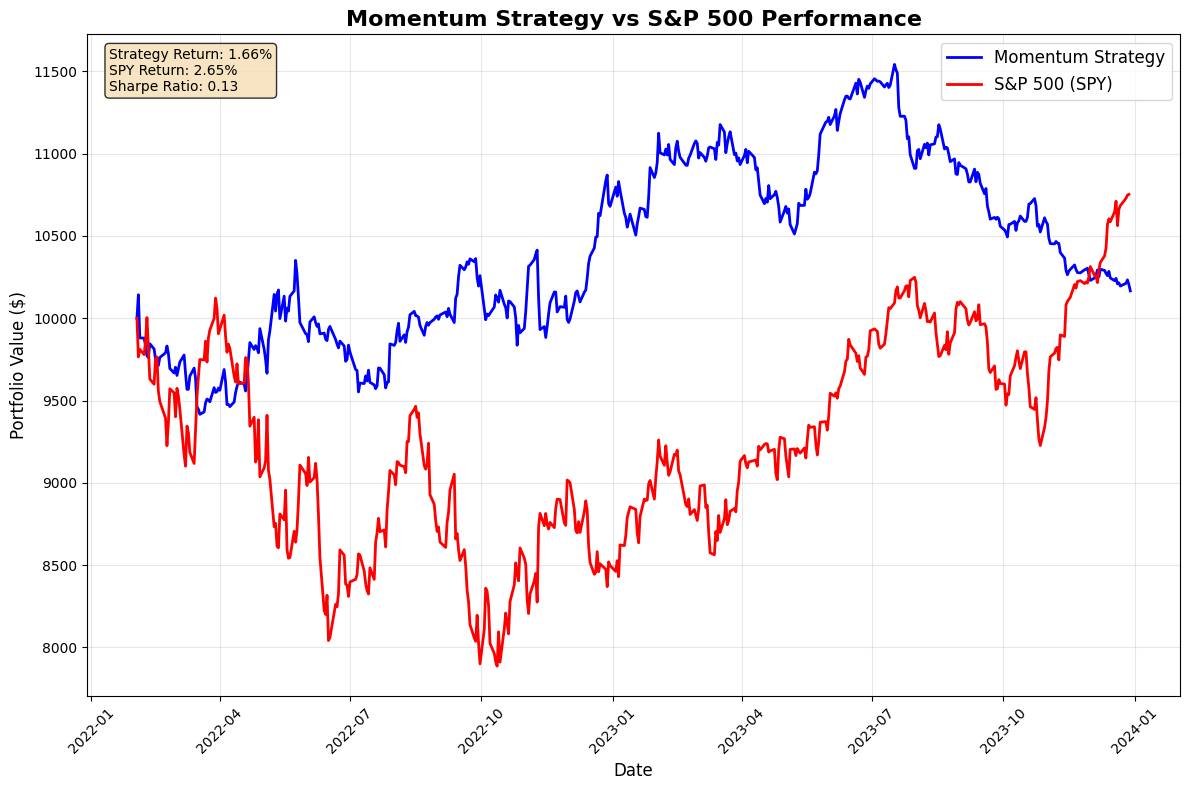

🎉 PROJECT COMPLETE! 🎉

What you've built:
✅ A quantitative momentum trading strategy
✅ A backtesting framework
✅ Performance analysis with key metrics
✅ Professional visualization

This is exactly the type of project that shows quant firms you can:
• Work with financial data
• Implement systematic trading strategies
• Calculate risk-adjusted returns
• Think critically about results


In [14]:
# Create a performance visualization
plt.figure(figsize=(12, 8))

# Download SPY data aligned with our strategy dates
spy_aligned = yf.download('SPY', start=portfolio_performance.index[0], end=portfolio_performance.index[-1])['Close']

# Normalize both to start at $10,000 for comparison
strategy_normalized = (portfolio_performance / portfolio_performance.iloc[0]) * 10000
spy_normalized = (spy_aligned / spy_aligned.iloc[0]) * 10000

# Plot both lines
plt.plot(strategy_normalized.index, strategy_normalized.values, label='Momentum Strategy', linewidth=2, color='blue')
plt.plot(spy_normalized.index, spy_normalized.values, label='S&P 500 (SPY)', linewidth=2, color='red')

plt.title('Momentum Strategy vs S&P 500 Performance', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Portfolio Value ($)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Add performance text
plt.text(0.02, 0.98, f'Strategy Return: {strategy_return:.2f}%\nSPY Return: {spy_return:.2f}%\nSharpe Ratio: {strategy_sharpe:.2f}', 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

print("🎉 PROJECT COMPLETE! 🎉")
print("\nWhat you've built:")
print("✅ A quantitative momentum trading strategy")
print("✅ A backtesting framework")
print("✅ Performance analysis with key metrics")
print("✅ Professional visualization")
print("\nThis is exactly the type of project that shows quant firms you can:")
print("• Work with financial data")
print("• Implement systematic trading strategies") 
print("• Calculate risk-adjusted returns")
print("• Think critically about results")